blackPrice:  6.297254539086019
oneStepTree:  7.798504987524955
blackPrice:  6.297254539086019
oneStepTree1: 	 7.798504987524955
oneStepTree2: 	 8.212289615248919
blackPrice: 	 6.297254539086019
crrNStepTree: 	 6.296057152109465
crr Binomial Tree pricing time:  0.004562854766845703
BS close form formula pricing time:  0.0


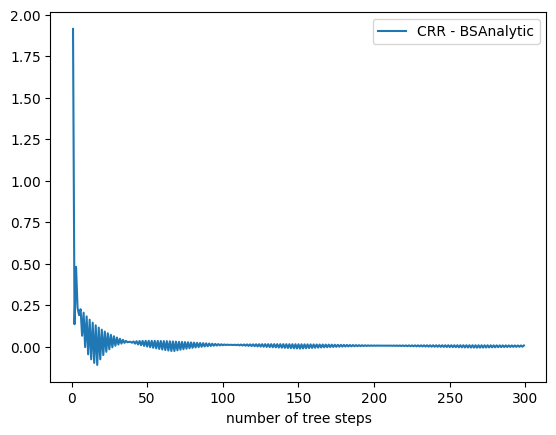

bsPrice = 	  6.297254539086019


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


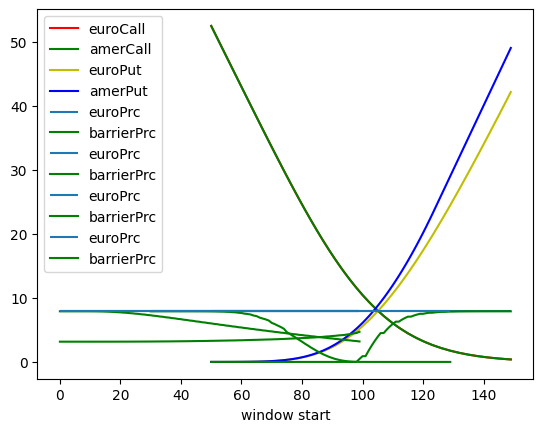

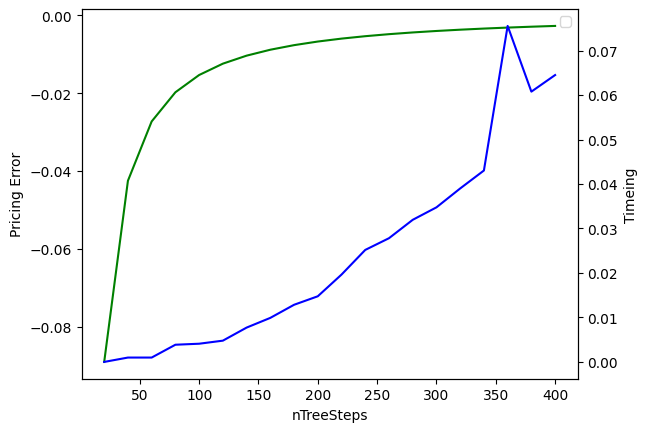

In [1]:
import math
import time

import numpy

from ipynb.fs.full.binomial import *

In [2]:
class KnockInOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def triggerBarrier(self, t, S):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return True
            elif self.downBarrier != None and S < self.downBarrier:
                return True
        return False
    # for knock-in options we define two states,
    # first state is the option value if the knock-in is not triggered in previous steps
    # second state is the option value if the knock-in has been triggered
    # and we merged payoff function, if continuation is none then it's the last time step
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            notKnockedInTerminalValue = 0
            if self.triggerBarrier(t, S):  # if the trade is not knocked in,
                # it is still possible to knock in at the last time step
                notKnockedInTerminalValue = self.underlyingOption.payoff(S)
                # if the trade is knocked in already
            knockedInTerminalValue = self.underlyingOption.payoff(S)
            return [notKnockedInTerminalValue, knockedInTerminalValue]
        else:
            nodeValues = continuation
            # calculate state 0: if no hit at previous steps
            if self.triggerBarrier(t, S):
                nodeValues[0] = continuation[1]
            # otherwise just carrier the two continuation values
        return nodeValues

In [3]:
class KnockOutOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def payoff(self, S):
        return self.underlyingOption.payoff(S)
    def valueAtNode(self, t, S, continuation):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return 0
            elif self.downBarrier != None and S < self.downBarrier:
                return 0
        return continuation

In [4]:
class TRF:
    def __init__(self, asset, fixings, payoffFun, targetGain):
        self.fixings = fixings
        self.payoffFun = payoffFun
        self.asset = asset
        self.targetGain = targetGain
    def AllDate(self):
        return self.fixings
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.fixings[-1])
        accum, discountedPO = 0
        for t in self.fixings:
            df = fobs["DF.USD"](t)
            po = self.payoffFun(fobs[self.asset])(t)
            accum += po
            discountedPO += df * po;
            if (accum > self.targetGain):
                break # triggers knockout
        return discountedPO
    def AssetNames(self):
        return [self.asset]

In [5]:
class AsianOption():
    def __init__(self, asset, fixings, payoffFun, As, nT):
        self.fixings = fixings
        self.payoffFun = payoffFun
        self.expiry = fixings[-1]
        self.nFix = len(fixings)
        self.As, self.nT, self.dt = As, nT, self.expiry / nT
        self.asset = asset
    def onFixingDate(self, t):
        # we say t is on a fixing date if there is a fixing date in (t-dt, t]
        return filter(lambda x: x > t - self.dt and x<=t, self.fixings)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return [self.payoffFun((a*float(self.nFix-1) + S)/self.nFix) for a in self.As]
        else:
            nodeValues = continuation
            if self.onFixingDate(t):
                i = len(list(filter(lambda x: x < t, self.fixings))) # number of previous fixings
                if i > 0:
                    Ahats = [(a*(i-1) + S)/i for a in self.As]
                    nodeValues = [numpy.interp(a, self.As, continuation) for a in Ahats]
        return nodeValues
    def AllDate(self):
        return self.fixings
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.fixings[-1])
        avg = 0
        for t in self.fixings:
            avg += fobs[self.asset](t)
        return df * self.payoffFun(avg / self.nFix)
    def AssetNames(self):
        return [self.asset]

In [6]:
class SpreadOption():
    def __init__(self, asset1, asset2, expiry):
        self.expiry = expiry
        self.asset1, self.asset2 = asset1, asset2
    def payoff(self, S1, S2):
        return max(S1-S2, 0)
    def valueAtNode(self, t, S1, S2, continuation):
        return continuation
    def AssetNames(self):
        return [self.asset1, self.asset2, "DF.USD"]
    def AllDates(self):
        return [self.expiry]
    def DiscountedMCPayoff(self, fobs):
        df = fobs["DF.USD"](self.expiry)
        s1 = fobs[self.asset1](self.expiry)
        s2 = fobs[self.asset2](self.expiry)
        return df * max(s1 - s2, 0)

In [7]:
def binomialPricerX(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.valueAtNode(trade.expiry, S * u ** (n - i) * d ** i, None) for i in range(n + 1)]
    numStates = len(vs[0])
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = [math.exp(-r * t) * (vs[j][k] * p + vs[j + 1][k] * (1 - p)) for k in range(numStates)]
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0][0]

kiPrice =  6.001588670701864
koPrice =  0.2944684814077655
euroPrice =  6.296057152109632
KIKO =  6.296057152109629


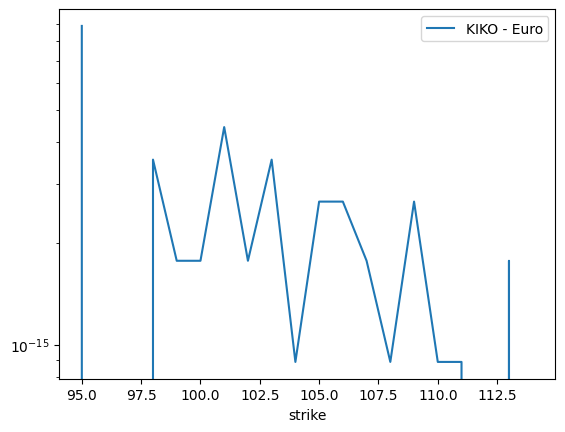

In [8]:
# Tests
def testKIKO():
    S, r, vol = 100, 0.01, 0.2
    opt = EuropeanOption(1, 105, PayoffType.Call)
    kiPrice = binomialPricerX(S, r, vol, KnockInOption(90, 120, 0, 1, opt), 300, crrCalib)
    koPrice = binomialPricer(S, r, vol, KnockOutOption(90, 120, 0, 1, opt), 300, crrCalib)
    euroPrice = binomialPricer(S, r, vol, opt, 300, crrCalib)
    print("kiPrice = ", kiPrice)
    print("koPrice = ", koPrice)
    print("euroPrice = ", euroPrice)
    print("KIKO = ", kiPrice + koPrice)
    kis = [
        binomialPricerX(S, r, vol, KnockInOption(90, 120, 0, 1, EuropeanOption(1, k, PayoffType.Call)), 300, crrCalib)
        for k in range(95, 115)]
    kos = [
        binomialPricer(S, r, vol, KnockOutOption(90, 120, 0, 1, EuropeanOption(1, k, PayoffType.Call)), 300, crrCalib)
        for k in range(95, 115)]
    euros = [binomialPricer(S, r, vol, EuropeanOption(1, k, PayoffType.Call), 300, crrCalib) for k in range(95, 115)]
    kikos = [abs(kis[i] + kos[i] - euros[i]) for i in range(len(kis))]
    plt.plot(range(95, 115), kikos, label="KIKO - Euro")
    plt.legend();
    plt.xlabel('strike');
    plt.yscale('log')  # plot on log scale
    # plt.savefig('../figs/kiko.eps', format='eps')
    plt.show()

if __name__ == "__main__":
    testKIKO()

In [9]:
def testAsian():
    S, r, vol = 100, 0.01, 0.2
    payoff = lambda A: max(A - 100, 0)
    As = np.arange(50, 150, 5).tolist()
    nT = 200

    asian = AsianOption("Stock1", [0.2, 0.4, 0.6, 0.8, 1.0], payoff, As, nT)
    euro = EuropeanOption(1.0, 100, PayoffType.Call)
    asianPrc = binomialPricerX(S, r, vol, asian, nT, crrCalib)
    print("asian price: ", asianPrc)

    euroPrc = binomialPricer(S, r, vol, euro, nT, crrCalib)
    print("euro price: ", euroPrc)

    asian1 = AsianOption("Stock1", [1.0], payoff, As, nT)
    asian1Prc = binomialPricerX(S, r, vol, asian1, nT, crrCalib)
    print("sanity check asian1 price: ", asian1Prc)
if __name__ == "__main__":
    testAsian()

asian price:  8.097540706544779
euro price:  8.423979990762623
sanity check asian1 price:  8.423979990762623


In [10]:
# additive Binomial Tree
def additiveBinomialTree(S, r, q, vol, T, n):
    t = T / n
    treeNodes = [[0]] # at t = 0, only one node,
    probs = [[]]
    dx = vol * math.sqrt(t)
    for i in range(1, n+1):
        # calculate the value of each node at time slide i, there are i+1 nodes
        slice = [0] * (i+1)
        for j in range(i):
            slice[j] = treeNodes[i-1][j] + dx
        slice[i] = treeNodes[i-1][i-1] - dx
        prob = [0] * (i)
        for j in range(i):
            prob[j] = ((r-q-0.5*vol*vol)*t + dx) / 2 / dx
        treeNodes.append(slice)
        probs.append(prob)
    return treeNodes, probs

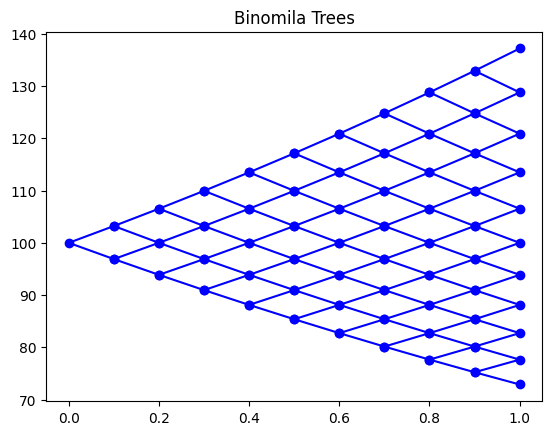

probs:  [[], [0.5237170824512629], [0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.5237170824512629], [0.5237170824512629, 0.5237170824512629, 0.5237170824512629, 0.523717

In [11]:
def testadditiveBinomialTree():
    S0, r, q, vol = 100, 0.03, 0.01, 0.1
    T, nT = 1, 10
    dt = T / nT
    treeNodes, probs = additiveBinomialTree(S0, r, q, vol, T, nT)
    fig = plt.figure()
    for i in range(len(treeNodes)-1):
        x = [dt, 0, dt]
        for j in range(i):
            x += [0, dt]
        x = np.array(x) + i*dt
        y = treeNodes[i] + treeNodes[i+1]
        y.sort()
        y = [S0 * math.exp(x) for x in y]
        plt.plot(x, y, 'bo-')
    plt.title("Binomila Trees")
    plt.show()
    print("probs: ", probs)
if __name__ == "__main__":
    testadditiveBinomialTree()

In [12]:
# Sread Option with 2-D Binomial Tree
def margrabe(S1, S2, q1, q2, vol1, vol2, rho, T):
    sigma = math.sqrt(vol1*vol1 + vol2*vol2 - 2*rho*vol1*vol2)
    stdev = sigma * math.sqrt(T)
    d1 = (math.log(S1 / S2) + (q2 - q1) * T) / stdev + stdev / 2
    d2 = d1 - stdev
    return math.exp(-q1*T) * S1 * cnorm(d1) - math.exp(-q2*T) * S2 * cnorm(d2)


In [13]:
def calib2D(r, q1, q2, vol1, vol2, rho, t):
    sqrtt = math.sqrt(t)
    v1 = r - q1 - vol1 * vol1 / 2
    v2 = r - q2 - vol2 * vol2 / 2
    x1 = vol1 * sqrtt
    x2 = vol2 * sqrtt
    a = x1 * x2
    b = x2 * v1 * t
    c = x1 * v2 * t
    d = rho * vol1 * vol2 * t
    puu = (a + b + c + d)/4/a
    pud = (a + b - c - d)/4/a
    pdu = (a - b + c - d)/4/a
    pdd = (a - b - c + d)/4/a
    return (x1, x2, puu, pud, pdu, pdd)

In [14]:
def binomialPricer2D(S1, S2, r, q1, q2, vol1, vol2, rho, trade, n):
    t = trade.expiry / n
    (x1, x2, puu, pud, pdu, pdd) = calib2D(r, q1, q2, vol1, vol2, rho, t)
    vs = numpy.zeros(shape=(n+1, n+1))
    for i in range(n+1):
        s1i = S1 * math.exp(x1 * (n - 2 * i))
        for j in range(n+1):
            s2j = S2 * math.exp(x2 * (n - 2*j))
            vs[i, j] = trade.payoff(s1i, s2j)
    # iterate backward
    for k in range(n - 1, -1, -1):
        # calculate the value of each node at time slide k, there are (k+1) x (k+1) nodes
        for i in range(k + 1):
            s1i = S1 * math.exp(x1 * (k - 2*i))
            for j in range(k + 1):
                s2j = S2 * math.exp(x2 * (k - 2*j))
                continuation = math.exp(-r * t) * (vs[i, j] * puu + vs[i, j+1] * pud + vs[i+1, j] * pdu + vs[i+1, j+1] * pdd)
                vs[i, j] = trade.valueAtNode(t * k, s1i, s2j, continuation)
    return vs[0, 0]

margrabe formula price:  6.826621633030797
2D Binomial Tree price:  6.824402388307022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


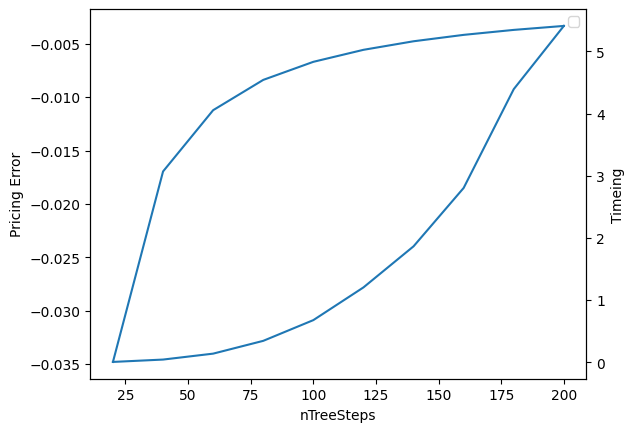

In [15]:
def testSpreadOption():
    S1, S2, r, q1, q2, vol1, vol2, rho = 100, 100, 0.05, 0.02, 0.03, 0.15, 0.2, 0.6
    spreadOption = SpreadOption("STOCK1", "STOCK2", expiry = 1)
    refPrice = margrabe(S1, S2, q1, q2, vol1, vol2, rho, T = 1.0)
    print("margrabe formula price: ", refPrice)
    print("2D Binomial Tree price: ",binomialPricer2D(S1, S2, r, q1, q2, vol1, vol2, rho, spreadOption, 300))

    n = 10
    prc = [None] * n
    timing = [None] * n
    nSteps = [None] * n
    for i in range(1, n+1):
        nSteps[i - 1] = 20 * i
        start = time.time()
        prc[i-1] = binomialPricer2D(S1, S2, r, q1, q2, vol1, vol2, rho, spreadOption, nSteps[i-1]) - refPrice
        timing[i-1] = time.time() - start

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(nSteps, prc)
    ax2.plot(nSteps, timing)

    ax1.set_xlabel('nTreeSteps')
    ax1.set_ylabel('Pricing Error')
    ax2.set_ylabel('Timeing')
    plt.legend()
    plt.show()
if __name__ == "__main__":    
    testSpreadOption()

In [16]:
# Trinomial Tree pricer
def trinomialPricer(S, r, q, vol, trade, n, lmda):
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t))
    mu = r - q
    pu = 1 / 2 / lmda / lmda + (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pd = 1 / 2 / lmda / lmda - (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pm = 1 - pu - pd
    # set up the last time slice, there are 2n+1 nodes at the last time slice
    # counting from the top, the i-th node's stock price is S * u^(n - i), i from 0 to n+1
    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = math.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

bsPrice = 	  6.297254539086019
Trinomial tree Price = 	  6.296274585898225


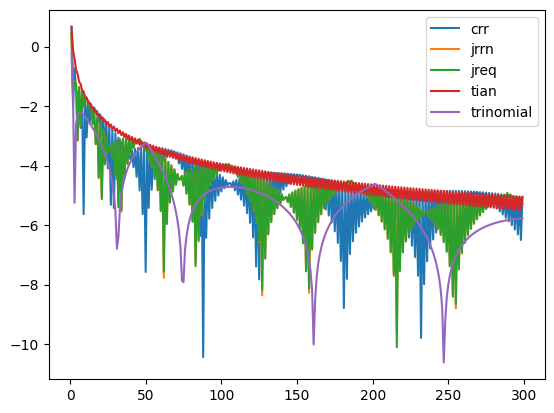

In [17]:
def testTrinomial():
    S, r, vol = 100, 0.01, 0.2
    opt = EuropeanOption(1, 105, PayoffType.Call)
    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)

    prc = trinomialPricer(S, r, 0, vol, opt, 500, math.sqrt(3))
    print("Trinomial tree Price = \t ", prc)
    n = 300
    crrErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, crrCalib) - bsprc)) for i in range(1, n)]
    jrrnErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jrrnCalib) - bsprc)) for i in range(1, n)]
    jreqErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jreqCalib) - bsprc)) for i in range(1, n)]
    tianErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, tianCalib) - bsprc)) for i in range(1, n)]
    triErrs = [math.log(abs(trinomialPricer(S, r, 0, vol, opt, i, math.sqrt(3)) - bsprc)) for i in range(1, n)]
    plt.plot(range(1, n), crrErrs, label="crr")
    plt.plot(range(1, n), jrrnErrs, label="jrrn")
    plt.plot(range(1, n), jreqErrs, label="jreq")
    plt.plot(range(1, n), tianErrs, label="tian")
    plt.plot(range(1, n), triErrs, label="trinomial")
    plt.legend()
    plt.show()
if __name__ == "__main__":
    testTrinomial()